## Convnet practice with kidney dataset

Changes - keeping epochs at 40, adding variable learning rate

In [1]:
# import cell
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
import json
from keras.callbacks import ReduceLROnPlateau

2025-05-10 11:59:25.140873: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 11:59:25.175789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746903565.194383  552372 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746903565.199988  552372 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746903565.229084  552372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Data Preparation

In [2]:
# seed setting and defaults for being good and clean
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [3]:
# setting up some ids for saving
model_id = "baseline_reduceLR_Plateau"  # Or whatever naming scheme you want
model_save_path = f"models/{model_id}.weights.h5"

In [4]:
# split dataset into train, validate, test
ds_train, ds_validate = image_dataset_from_directory(r'../input/kaggle/ct-kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone',
                                  labels='inferred',
                                  label_mode = 'categorical',
                                  color_mode = 'grayscale',
                                  image_size = (256, 256),
                                  shuffle = True,
                                  validation_split = 0.2,
                                  subset = 'both',
                                  seed = 314,
                                  batch_size = 16)
val_size = int(0.5 * tf.data.experimental.cardinality(ds_validate).numpy())

ds_val = ds_validate.take(val_size)
ds_test = ds_validate.skip(val_size)
ds_val.class_names = ds_validate.class_names
ds_test.class_names = ds_validate.class_names


Found 12446 files belonging to 4 classes.
Using 9957 files for training.
Using 2489 files for validation.


I0000 00:00:1746904981.961914  552372 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
def get_class_distribution(dataset, class_names):
    label_counts = np.zeros(len(class_names), dtype=int)
    total = 0
    for _, labels in dataset:
        indices = tf.argmax(labels, axis=1).numpy()
        for i in indices:
            label_counts[i] += 1
            total += 1
    percent_distribution = {class_names[i]: round(100 * count / total, 2) for i, count in enumerate(label_counts)}
    return percent_distribution

print("Train class %:")
print(get_class_distribution(ds_train, ds_train.class_names))

Train class %:
{'Cyst': np.float64(29.72), 'Normal': np.float64(41.05), 'Stone': np.float64(11.12), 'Tumor': np.float64(18.12)}


2025-05-10 12:23:06.934991: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Model Declaration and Compiling

In [6]:
# Define augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation_layer")

model = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    data_augmentation,   
    layers.Conv2D(filters=32, kernel_size=5, activation = 'relu', padding = 'same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters = 64, kernel_size=3, activation = 'relu', padding = 'same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPool2D(),
    # time for the head
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=4, activation = 'softmax')
])

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,676 (237.02 KB)

 Trainable params: 60,676 (237.02 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon=0.01),
    loss = 'categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

In [9]:
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=40,
    callbacks=[lr_schedule]
)

Epoch 1/40


I0000 00:00:1746905159.162744  563318 cuda_dnn.cc:529] Loaded cuDNN version 90300


623/623 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5000 - loss: 1.4750 - precision: 0.5896 - recall: 0.2749 - val_accuracy: 0.5817 - val_loss: 1.1661 - val_precision: 0.5961 - val_recall: 0.4127 - learning_rate: 0.0010
Epoch 2/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6375 - loss: 0.9791 - precision: 0.7312 - recall: 0.5042 - val_accuracy: 0.6498 - val_loss: 0.9288 - val_precision: 0.7047 - val_recall: 0.5986 - learning_rate: 0.0010
Epoch 3/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6541 - loss: 0.9203 - precision: 0.7422 - recall: 0.5372 - val_accuracy: 0.6418 - val_loss: 0.9974 - val_precision: 0.7074 - val_recall: 0.5385 - learning_rate: 0.0010
Epoch 4/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6490 - loss: 0.8998 - precision: 0.7551 - recall: 0.5259 - val_accuracy: 0.6538 - val_loss: 0.8641 - val_precision: 0.7358 - val_recall: 0.5825 - learning_rate: 0.0010
Epoch 5/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0

In [10]:
model.save_weights(model_save_path)

In [11]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=ds_test.class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2025-05-10 12:36:06.866196: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

2025-05-10 12:36:11.233923: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Axes: >

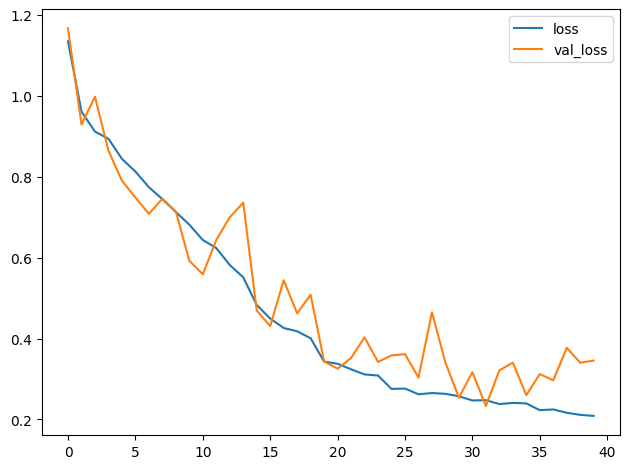

In [12]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()

In [13]:
print("Train class %:")
print(get_class_distribution(ds_test, ds_test.class_names))

Train class %:
{'Cyst': np.float64(31.91), 'Normal': np.float64(38.6), 'Stone': np.float64(9.83), 'Tumor': np.float64(19.66)}


In [14]:
preds = model.predict(ds_test)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [15]:
preds

array([[4.0006977e-05, 2.3692218e-04, 5.1823235e-08, 9.9972302e-01],
       [2.3981973e-03, 9.0245284e-02, 3.9110370e-02, 8.6824614e-01],
       [1.3998201e-13, 9.8337501e-01, 1.6624963e-02, 1.1497119e-09],
       ...,
       [1.7984062e-03, 1.2772563e-01, 1.2859773e-02, 8.5761625e-01],
       [7.5814569e-07, 2.1911173e-01, 4.4018594e-05, 7.8084350e-01],
       [7.2265398e-13, 7.3167217e-01, 2.6832777e-01, 4.6729507e-08]],
      dtype=float32)

In [16]:
y_pred = np.argmax(preds, axis=1)

In [17]:
y_true = []
for _, labels in ds_test:
    y_true.extend(tf.argmax(labels, axis=1).numpy())


2025-05-10 12:36:12.645352: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=ds_test.class_names))


              precision    recall  f1-score   support

        Cyst       0.94      0.95      0.95       396
      Normal       0.88      0.92      0.90       479
       Stone       0.61      0.86      0.71       122
       Tumor       0.99      0.68      0.80       244

    accuracy                           0.88      1241
   macro avg       0.86      0.85      0.84      1241
weighted avg       0.89      0.88      0.88      1241



In [19]:
for i in range(5):
    print(f"Predicted: {ds_test.class_names[y_pred[i]]}")
    print(f"Confidence: {np.max(preds[i]):.4f}")
    print(f"All probs: {preds[i]}")
    print("---")


Predicted: Tumor
Confidence: 0.9997
All probs: [4.0006977e-05 2.3692218e-04 5.1823235e-08 9.9972302e-01]
---
Predicted: Tumor
Confidence: 0.8682
All probs: [0.0023982  0.09024528 0.03911037 0.86824614]
---
Predicted: Normal
Confidence: 0.9834
All probs: [1.3998201e-13 9.8337501e-01 1.6624963e-02 1.1497119e-09]
---
Predicted: Stone
Confidence: 0.6873
All probs: [0.15895344 0.12967075 0.68728966 0.02408617]
---
Predicted: Cyst
Confidence: 0.7506
All probs: [7.5061065e-01 9.6809908e-06 2.4936706e-01 1.2600000e-05]
---


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


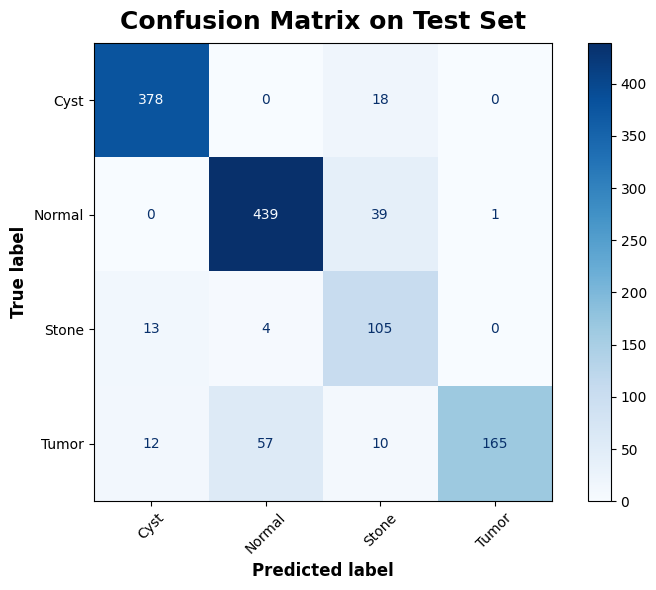

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# First get predictions and true labels (you’ve likely already done this)
y_pred = np.argmax(model.predict(ds_test), axis=1)
y_true = []
for _, labels in ds_test:
    y_true.extend(tf.argmax(labels, axis=1).numpy())

# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ds_test.class_names)

# Plot it
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()


In [21]:

# Convert Keras history to DataFrame
hist_df = pd.DataFrame(history.history)

# Save to CSV
hist_df.to_csv(f"logs/{model_id}_history.csv", index=False)

In [22]:
report = classification_report(y_true, y_pred, target_names=ds_test.class_names, output_dict=True)

with open(f"logs/{model_id}_classification_report.json", "w") as f:
    json.dump(report, f, indent=4)


with open(f"logs/{model_id}_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
